# White Nose Syndrome Gone "Batty" Project Notebook

<hr>
Bella Larson, Elizabeth Letch, Chloe Marshall, Serena Strode

| <a href="/WNS Gone Batty-intropage.html">Introduction</a>|<a href="/WNS Gone Batty-pre-processing.html">Preprocessing</a>|<a href="/WNS Gone Batty-model building.html">Model Building</a>|<a href="/WNS Gone Batty-discussion.html">Discussion</a>|<a href="/WNS Gone Batty-references.html">References</a>|
| ------------- | ------------- | ------------- | ------------- | ------------- |

In [3]:
%%capture test
%run ./"WNS Gone Batty-pre-processing.ipynb"

### Creating an Epidemic Model

Using this new data frame, we wanted to create a working epidemiology model, based on methods used in class. Since the disease first started in the Eastern timezone, we had the largest and most complete data set for that region. We used the Eastern region data as the foundation for the epidemiology model.

In [5]:
# Isolate the Eastern Region as it is where WNS first appeared (Most complete data over time)
Region = "Eastern"
df_eastern = df2[df2["region"] == Region]
df_eastern

,region,status_season,wns_pos,pd_pos,wns_suspected,pd_presumed
54,Eastern,2006-07,2,14,0,0
55,Eastern,2007-08,16,25,0,0
56,Eastern,2008-09,41,31,2,0
57,Eastern,2009-10,72,36,7,0
58,Eastern,2010-11,108,38,19,0
59,Eastern,2011-12,145,27,23,0
60,Eastern,2012-13,171,19,34,1
61,Eastern,2013-14,188,17,41,1
62,Eastern,2014-15,198,11,47,1
63,Eastern,2015-16,201,13,50,1


We established three populations: healthy $(h)$, Pd positive $(p)$, and WNS positive $(w)$. We created three differential equations to model the spread of the disease:
$$\begin{align} \\
\frac{dh}{dt} &= -ahp \\
\frac{dp}{dt} &= ahp - kp \\
\frac{dw}{dt} &= kp
\end{align}$$

Breaing down the parameters, $a$ is the infection rate of the $Pd$ fungus and $k$ is the rate of WNS occurance. The healthy population declines based on the infection rate and number of $Pd$ positive cases. The $Pd$ positive population increases with healthy bats becoming infected and decreases as bats succumb to WNS. The WNS positive population increases with an increasing population of $Pd$ positive bats becoming WNS positive. 

To create the best possible model projections, chi squared optimization was used to find the ideal constant values for $a$ and $k$. This was done by comparing models to the true data of WNS positive cases in the Eastern region to find the optimal constant vales. Doing this gave us values for the constants that we could assume to be universal to how WNS spreads, and thus used for projections in other regions.

In [7]:
def chi_squared(params,data,t):

    # unpacking the parameters 
    a = params[0]
    k = params[1]
    
    # compute the fit
    integrated = scipy.integrate.odeint(epidemic_rhs, hpw_0, t, args=(a, k))

    fit = integrated[:,2]
    # computing the chi-squared
    vals = (data - fit)**2 / fit
    
    return np.sum(vals)

[0.00696272 0.60758136]


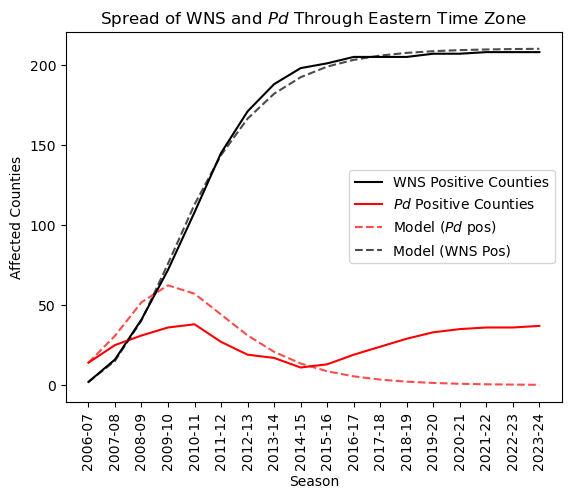

In [8]:
# Create time list to integrate over
t = np.arange(0,18)


# Create epidemic model with differential equations
def epidemic_rhs(hpw, t, a, k):
    h,p,w = hpw
    dh_dt = -a * h * p  
    dp_dt = a * h * p - k * p
    dw_dt = k * p 
    
    return np.array([dh_dt, dp_dt, dw_dt])


# Create inital conditions for healthy, Pd positive, and WNS positive counties
# Healthy counties found by dividing total counties in North America with caves evenly amongst time zones
hpw_0 = [214, 14, 2]


# Create variable values by optimizing with chi squared
ans = scipy.optimize.minimize(chi_squared, [0.006, 0.7], args=(df_eastern["wns_pos"], t),
                       bounds=[ (0, 1), (0, 1) ] )

print(ans.x)

a = ans.x[0]
k = ans.x[1]

# Solve for model projections
hpw = scipy.integrate.odeint(epidemic_rhs, hpw_0, t, args=(a, k))
h = hpw[:,0]
p = hpw[:,1]
w = hpw[:,2]


# Plot the results
plt.plot(df_eastern["status_season"], df_eastern["wns_pos"], label="WNS Positive Counties", color = 'black')
plt.plot(df_eastern["status_season"], df_eastern["pd_pos"], label="$Pd$ Positive Counties", color = 'red')
plt.plot(t, p, '--', color = 'red', alpha = 0.7, label='Model ($Pd$ pos)')
plt.plot(t, w, '--', color = 'black', alpha = 0.7, label='Model (WNS Pos)')
plt.xlabel('Season')
plt.ylabel('Affected Counties')
plt.title('Spread of WNS and $Pd$ Through Eastern Time Zone')
plt.xticks(rotation = 90) 
plt.legend()
plt.show()

### Applying the Epidemic Model

Plotted above are the actual trend of $Pd$ positive counties and WNS positive in the Eastern region along with their predictive best fits from our integration equation above. We were able to obtain fairly close fits with our integration, as demonstrated in dashed lines. Using this model, we extended the concepts to the region that was infected next: the Central Region. 

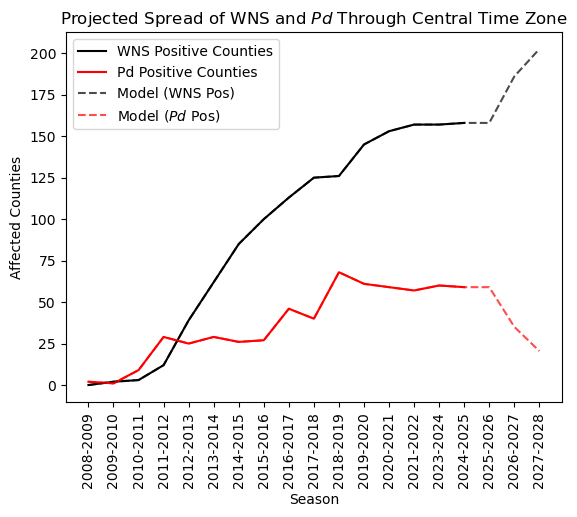

In [10]:
# Isolate region of interst
Region = "Central"
df4 = df2[df2["region"] == Region]

# Only find cases in the specific region where cases are present
df_central = df4[df4['pd_pos'] > 0]

remaining_int_t = np.arange(0,3)

# Use intial conditons of last staus season
hpw_0 = [15, 59, 158]

# Create list for axis labels
axis = ['2008-2009','2009-2010','2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016',
        '2016-2017','2017-2018','2018-2019','2019-2020','2020-2021','2021-2022','2023-2024','2024-2025',
        '2025-2026', '2026-2027', '2027-2028']


# Create list of time stamps to match labels to
axis_t = np.arange(0,19)

# Extrapolate with same epidemic model from above, using constants found to be best match in most complete data set
hpw = scipy.integrate.odeint(epidemic_rhs, hpw_0, remaining_int_t, args=(a, k))
h = hpw[:,0]
p = hpw[:,1]
w = hpw[:,2]


# Turn data frame into lists to be added to extrapolated data
pd_pos = df_central['pd_pos'].tolist()
wns_pos = df_central['wns_pos'].tolist()


# Combine extrapolated data and current data to be plotted
for extrapolated in p:
    pd_pos.append(extrapolated)

for extrapolated in w:
    wns_pos.append(extrapolated)

# Plot results
plt.plot(df_central["status_season"], df_central["wns_pos"], label="WNS Positive Counties", color = 'black');
plt.plot(df_central["status_season"], df_central["pd_pos"], label="Pd Positive Counties", color = 'red')
plt.plot(wns_pos,'--', color = 'black', alpha = 0.7, label='Model (WNS Pos)')
plt.plot(pd_pos, '--', color = 'red', alpha = 0.7, label='Model ($Pd$ Pos)')
plt.xlabel('Season')
plt.ylabel('Affected Counties')
plt.title('Projected Spread of WNS and $Pd$ Through Central Time Zone')
plt.xticks(axis_t, axis)
plt.xticks(rotation = 90)
plt.legend()
plt.show()

Using the epidemic model we created with data for the Eastern region, we were able to extend and extrapolate data for the Central region. The dashed lines show a projection for the $Pd$ positive and WNS positive populations. We continued this same pattern with the Mountain region below. 

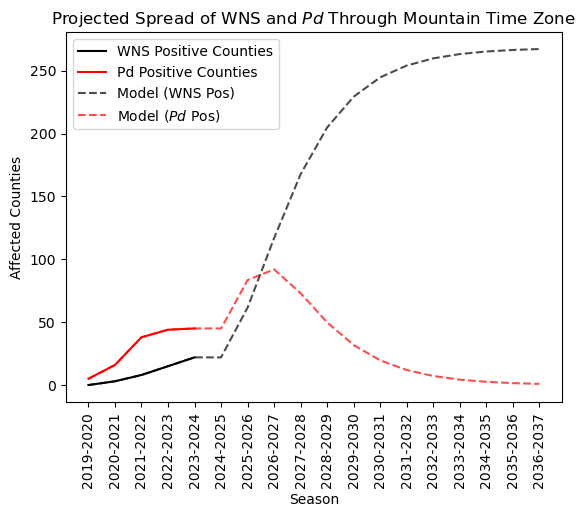

In [12]:
# Isolate region of interst
Region = "Mountain"
df4 = df2[df2["region"] == Region]

# Only find cases in the specific region where cases are present
df_mountain = df4[df4['pd_pos'] > 0]


# Use intial conditons of last staus season
hpw_0 = [214, 45, 22]

#Create list for axis labels
axis = ['2019-2020','2020-2021','2021-2022','2022-2023','2023-2024','2024-2025','2025-2026','2026-2027',
        '2027-2028','2028-2029','2029-2030','2030-2031','2031-2032','2032-2033','2033-2034','2034-2035','2035-2036',
        '2036-2037']

# Create list for remaining time to get to 18 seasons of data
remaining_int_t = np.arange(0,13)


# Create list of time stamps to match labels to
axis_t = np.arange(0,18)

# Extrapolate with same epidemic model from above, using constants found to be best match in most complete data set
hpw = scipy.integrate.odeint(epidemic_rhs, hpw_0, remaining_int_t, args=(a, k))
h = hpw[:,0]
p = hpw[:,1]
w = hpw[:,2]


# Turn data frame into lists to be added to extrapolated data
pd_pos = df_mountain['pd_pos'].tolist()
wns_pos = df_mountain['wns_pos'].tolist()


# Combine extrapolated data and current data to be plotted
for extrapolated in p:
    pd_pos.append(extrapolated)

for extrapolated in w:
    wns_pos.append(extrapolated)

# Plot results
plt.plot(df_mountain["status_season"], df_mountain["wns_pos"], label="WNS Positive Counties", color = 'black');
plt.plot(df_mountain["status_season"], df_mountain["pd_pos"], label="Pd Positive Counties", color = 'red')
plt.plot(wns_pos,'--', color = 'black', alpha = 0.7, label='Model (WNS Pos)')
plt.plot(pd_pos, '--', color = 'red', alpha = 0.7, label='Model ($Pd$ Pos)')
plt.xlabel('Season')
plt.ylabel('Affected Counties')
plt.title('Projected Spread of WNS and $Pd$ Through Mountain Time Zone')
plt.xticks(axis_t, axis)
plt.xticks(rotation = 90)
plt.legend()
plt.show()

Most of this data is extrapolated, a projection based on our epidemic model. However, since WNS is still so new to the Mountain region, our model can serve as a valuable indicator of what may be coming for the bat populations in this region over the next decade or so.

| <a href="/WNS Gone Batty-intropage.html">Introduction</a>|<a href="/WNS Gone Batty-pre-processing.html">Preprocessing</a>|<a href="/WNS Gone Batty-model building.html">Model Building</a>|<a href="/WNS Gone Batty-discussion.html">Discussion</a>|<a href="/WNS Gone Batty-references.html">References</a>|
| ------------- | ------------- | ------------- | ------------- | ------------- |